# Анализ датасета по продажам

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sales-forecasting/train.csv


In [2]:
df = pd.read_csv('/kaggle/input/sales-forecasting/train.csv', index_col=0)

In [3]:
df.head(3)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94
3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62


### Предобработка данных

In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format = '%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format = '%d/%m/%Y')

Будем работать с данными за последний год

In [5]:
df = df[df['Order Date'] >= '2018-01-01']
df = df.reset_index(drop = True)

In [6]:
df[df['Postal Code'].isnull()][['Customer Name', 'City', 'State']]

,Customer Name,City,State
664,Quincy Jones,Burlington,Vermont
3120,Raymond Messe,Burlington,Vermont
3121,Raymond Messe,Burlington,Vermont
3122,Raymond Messe,Burlington,Vermont
3123,Raymond Messe,Burlington,Vermont


У покупателей из Burlington, Vermont не указан почтовый код. Стоит выяснить причину - по датасету не понять, там просто null, поэтому я бы сообщил команде. Почтовые коды Burlington, Vermont: 05401, 05402, 05405, 05406, 05408

In [7]:
df['Postal Code'] = df['Postal Code'].fillna(5401)
df['Postal Code'] = df['Postal Code'].astype(int)

In [8]:
df['Delivery Time in Days'] = (df['Ship Date'] - df['Order Date']).dt.days

In [9]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Delivery Time in Days
0,CA-2018-114412,2018-04-15,2018-04-20,Standard Class,AA-10480,Andrew Allen,Consumer,United States,Concord,North Carolina,28027,South,OFF-PA-10002365,Office Supplies,Paper,Xerox 1967,15.552,5
1,US-2018-156909,2018-07-16,2018-07-18,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,Pennsylvania,19140,East,FUR-CH-10002774,Furniture,Chairs,"Global Deluxe Stacking Chair, Gray",71.372,2
2,CA-2018-107727,2018-10-19,2018-10-23,Second Class,MA-17560,Matt Abelman,Home Office,United States,Houston,Texas,77095,Central,OFF-PA-10000249,Office Supplies,Paper,Easy-staple paper,29.472,4
3,CA-2018-120999,2018-09-10,2018-09-15,Standard Class,LC-16930,Linda Cazamias,Corporate,United States,Naperville,Illinois,60540,Central,TEC-PH-10004093,Technology,Phones,Panasonic Kx-TS550,147.168,5
4,CA-2018-139619,2018-09-19,2018-09-23,Standard Class,ES-14080,Erin Smith,Corporate,United States,Melbourne,Florida,32935,South,OFF-ST-10003282,Office Supplies,Storage,"Advantus 10-Drawer Portable Organizer, Chrome ...",95.616,4


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3258 entries, 0 to 3257
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Order ID               3258 non-null   object        
 1   Order Date             3258 non-null   datetime64[ns]
 2   Ship Date              3258 non-null   datetime64[ns]
 3   Ship Mode              3258 non-null   object        
 4   Customer ID            3258 non-null   object        
 5   Customer Name          3258 non-null   object        
 6   Segment                3258 non-null   object        
 7   Country                3258 non-null   object        
 8   City                   3258 non-null   object        
 9   State                  3258 non-null   object        
 10  Postal Code            3258 non-null   int64         
 11  Region                 3258 non-null   object        
 12  Product ID             3258 non-null   object        
 13  Cat

## Рассчёт метрик

- DAU, WAU, MAU - аудитория в день, неделю, месяц
- Retention - кол-во пользователей, возвращающееся в продукт через Х временных периодов
- Средний чек и выручка по месяцам
- LTV (Life Time Value) - суммарные траты пользователя

### Active Users, Retention

In [11]:
ret_df = pd.DataFrame(columns = ['Customer ID'])
ret_df['Customer ID'] = df['Customer ID']

ret_df['Order Date'] = df['Order Date']
ret_df['Order Day'] = df['Order Date'].dt.day
ret_df['Order Week'] = df['Order Date'].dt.isocalendar().week
ret_df['Order Month'] = df['Order Date'].dt.month
ret_df['Order Year'] = df['Order Date'].dt.year

In [12]:
ret_df.head(3)

,Customer ID,Order Date,Order Day,Order Week,Order Month,Order Year
0,AA-10480,2018-04-15,15,15,4,2018
1,SF-20065,2018-07-16,16,29,7,2018
2,MA-17560,2018-10-19,19,42,10,2018


In [13]:
DAU = ret_df.groupby('Order Date').agg({'Customer ID': 'nunique'}).mean()
print("DAU = {0:.2f} человек в день".format(DAU[0]))

WAU = ret_df.groupby('Order Week').agg({'Customer ID': 'nunique'}).mean()
print("WAU = {0:.2f} человек в неделю".format(WAU[0]))

MAU = ret_df.groupby('Order Month').agg({'Customer ID': 'nunique'}).mean()
print("MAU = {0:.2f} человек в месяц".format(MAU[0]))

DAU = 5.14 человек в день
WAU = 31.13 человек в неделю
MAU = 125.33 человек в месяц


In [14]:
first_orders_df = df.groupby(['Customer ID'])['Order Date'].min().reset_index()
first_orders_df.columns = ['Customer ID', 'First Order Date']
first_orders_df.head(3)

,Customer ID,First Order Date
0,AA-10315,2018-06-29
1,AA-10375,2018-09-07
2,AA-10480,2018-04-15


In [15]:
ret_df = ret_df.merge(first_orders_df)
ret_df.head(3)

,Customer ID,Order Date,Order Day,Order Week,Order Month,Order Year,First Order Date
0,AA-10480,2018-04-15,15,15,4,2018,2018-04-15
1,SF-20065,2018-07-16,16,29,7,2018,2018-07-16
2,SF-20065,2018-11-01,1,44,11,2018,2018-07-16


In [16]:
ret_df['First Order Month'] = ret_df['First Order Date'].astype('datetime64[M]')
ret_df['Order Month DT'] = ret_df['Order Date'].astype('datetime64[M]')

ret_df['Lifetime'] = (ret_df['Order Month DT'] - ret_df['First Order Month']) / np.timedelta64(1, 'M')
ret_df['Lifetime'] = ret_df['Lifetime'].round().astype('int')

In [17]:
cohort_ret_df = ret_df.groupby(['First Order Month', 'Lifetime']).agg({'Customer ID': 'nunique'}).reset_index()
f_ID = cohort_ret_df[cohort_ret_df['Lifetime'] == 0][['First Order Month', 'Customer ID']]
f_ID.columns = ['First Order Month', 'f_ID']
f_ID.head()

,First Order Month,f_ID
0,2018-01-01,66
12,2018-02-01,49
23,2018-03-01,100
33,2018-04-01,77
42,2018-05-01,70


In [18]:
cohort_ret_df = cohort_ret_df.merge(f_ID)
cohort_ret_df['Retention'] = cohort_ret_df['Customer ID'] / cohort_ret_df['f_ID']
orders_retention_pivot = cohort_ret_df.pivot_table(index = 'First Order Month', 
                                                   columns = 'Lifetime', 
                                                   values = 'Retention', 
                                                   aggfunc = 'sum')

orders_retention_pivot.mean() * 100

Lifetime
0     100.000000
1      14.454058
2      17.109362
3      20.294266
4      18.394511
5      17.018751
6      21.277845
7      23.543599
8      25.789889
9      21.735931
10     26.406926
11     25.757576
dtype: float64

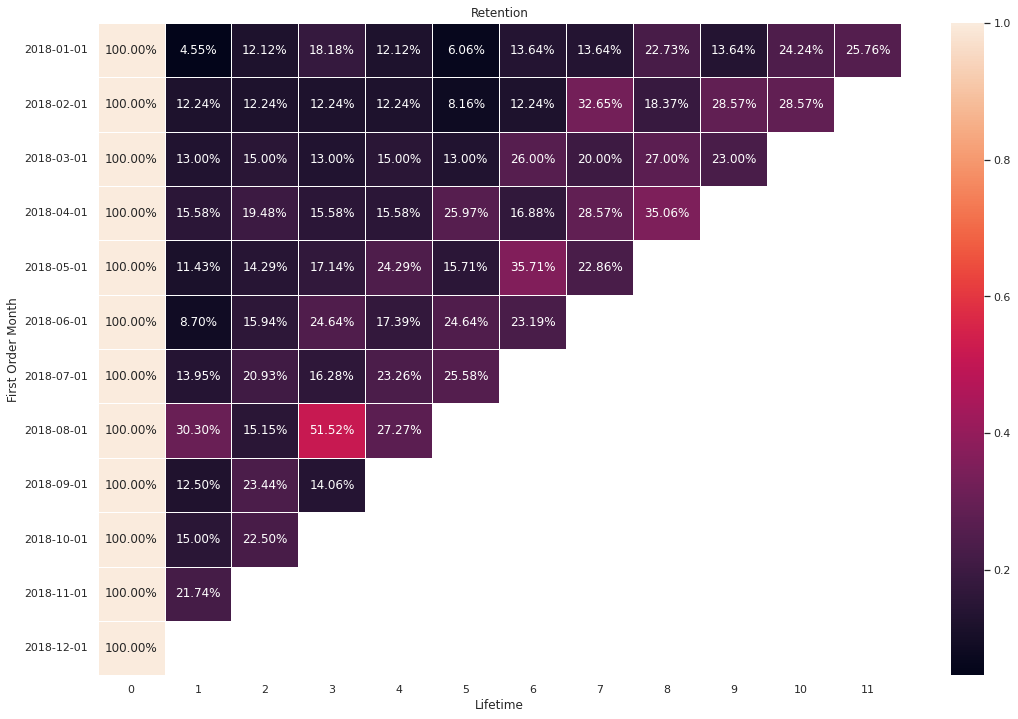

In [19]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (18, 12))
plt.title('Retention')

ax = sns.heatmap(orders_retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='white')
ax.set_yticklabels(orders_retention_pivot.index.date)
plt.show()

Retention вырос в сентябре и ноябре-декабре \
Половина покупателей, пришедших в августе, вернулись в ноябре

### Средний чек, LTV

In [20]:
ltv_df = df[['Customer ID', 'Order Date', 'Sales']]
ltv_df.head(3)

,Customer ID,Order Date,Sales
0,AA-10480,2018-04-15,15.552
1,SF-20065,2018-07-16,71.372
2,MA-17560,2018-10-19,29.472


In [21]:
ltv_df = ltv_df.merge(ret_df)
ltv_df.head(3)

,Customer ID,Order Date,Sales,Order Day,Order Week,Order Month,Order Year,First Order Date,First Order Month,Order Month DT,Lifetime
0,AA-10480,2018-04-15,15.552,15,15,4,2018,2018-04-15,2018-04-01,2018-04-01,0
1,SF-20065,2018-07-16,71.372,16,29,7,2018,2018-07-16,2018-07-01,2018-07-01,0
2,MA-17560,2018-10-19,29.472,19,42,10,2018,2018-10-19,2018-10-01,2018-10-01,0


[Text(0, 0.5, 'Число заказов'), Text(0.5, 0, 'Дата заказа')]

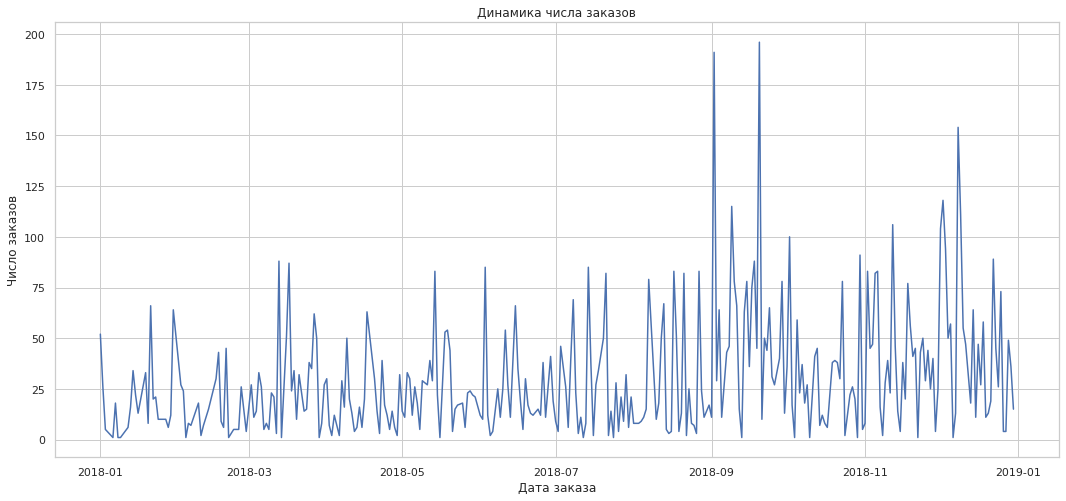

In [22]:
plt.figure(figsize=(18,8))
plt.title('Динамика числа заказов')
sns.lineplot(data = ltv_df.groupby('Order Date')['Customer ID'].count()).set(ylabel = 'Число заказов', xlabel = 'Дата заказа')

Наблюдается резкое увеличение количества заказов в сентябре

In [23]:
print('Значение среднего чека')
print('Среднее =', ltv_df['Sales'].mean().round(2))
print('Медианное =', ltv_df['Sales'].median().round(2))

Значение среднего чека
Среднее = 228.76
Медианное = 56.28


[Text(0, 0.5, '$'), Text(0.5, 0, 'Месяц')]

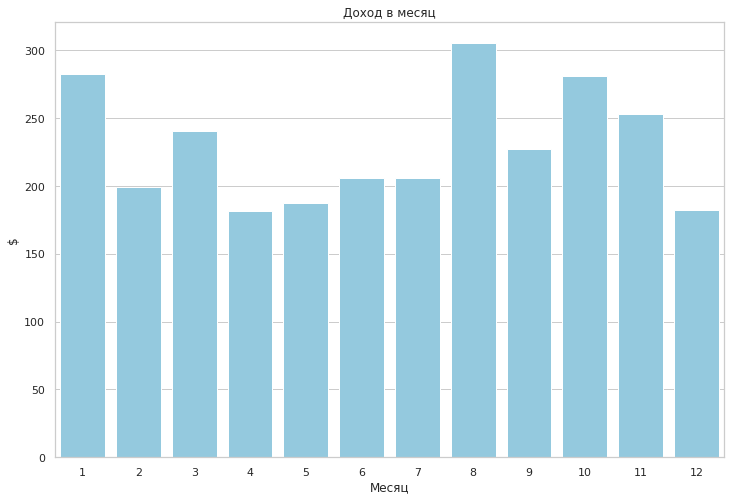

In [24]:
plt.figure(figsize=(12,8))
plt.title('Доход в месяц')
sns.barplot(data = ltv_df.groupby('Order Month', as_index = False).agg({'Sales': 'mean'}), 
            y = 'Sales', x = 'Order Month', color = 'Skyblue').set(ylabel = '$', xlabel = 'Месяц')

In [25]:
ltv = ltv_df.groupby(['First Order Month','Lifetime']).agg({'Sales':'sum'})
ltv = ltv.pivot_table(index='First Order Month', columns='Lifetime', values='Sales', aggfunc='sum')
ltv = ltv.cumsum(axis=1)

In [26]:
cohorts = (ltv_df.groupby('First Order Month').agg({'Customer ID':'count','Sales':'sum'})
                                             .rename(columns={'Customer ID':'Cohort Size'}))

In [27]:
ltv = cohorts[['Cohort Size']].join(ltv)
ltv = ltv.div(ltv['Cohort Size']*100, axis=0).drop(columns = ['Cohort Size'])

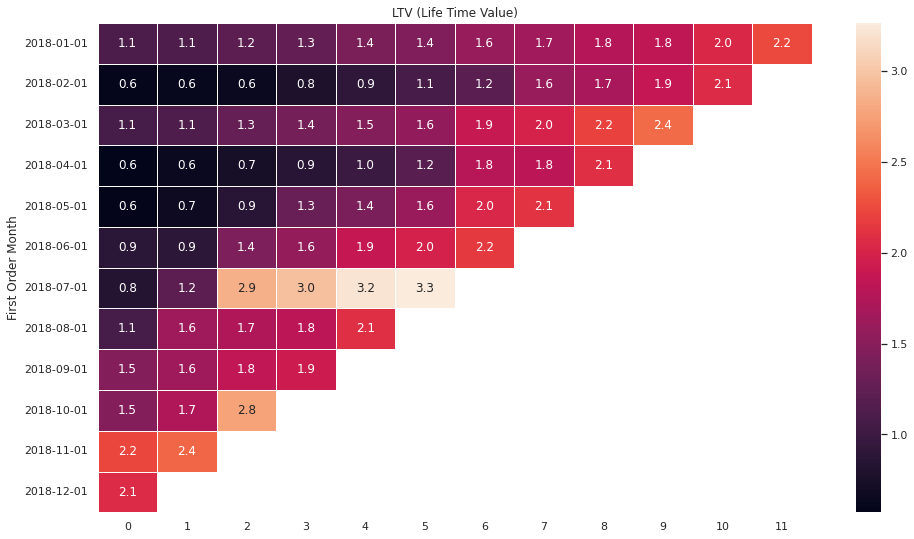

In [28]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('LTV (Life Time Value)')
ax = sns.heatmap(ltv, annot=True, fmt='.1f', linewidths=1, linecolor='white')
ax.set_yticklabels(ltv.index.date)
plt.show()

Покупатели, пришедшие в июле и октябре, резко увеличили свой показатель LTV в сентябре и декабре соответсвенно. Также суммарные траты новых покупателей активно выросли во второй половине года

## Выводы

Покупатели продолжают возвращаться, retention вырос в сентябре и ноябре-декабре \
(Половина покупателей, пришедших в августе, вернулись в ноябре)

В сентябре количество заказов резко увеличилось

Доход в месяц выше всего с августа по октябрь

Покупатели, пришедшие в июле и октябре, резко увеличили свой показатель LTV в сентябре и декабре соответсвенно. Также суммарные траты новых покупателей активно выросли во второй половине года

P. S. При наличии информации о действиях, направленных на рост метрик, можно делать выводы об эффективности этих действий